# Day 5: Volatility Forecasting Comparison

---

### 🎯 Learning Objectives
- Compare different volatility forecasting methods
- Implement HAR-RV model
- Evaluate forecast accuracy
- Understand realized volatility measures

---

### 📈 Why Forecasting Matters

| Long-term planning | Rolling |

**Better volatility forecasts = Better risk management = Better returns.**| Position sizing | EWMA |

| Options | HAR-RV |

### Methods Covered| VaR | GARCH |

- Rolling window (historical)|-------------|-------------|

- EWMA| Application | Best Method |

- GARCH family

- HAR-RV (Heterogeneous Autoregressive Realized Volatility)### Trading Applications



### Method Comparison| HAR-RV | Complex | Very fast | High-freq data |

| GARCH | Moderate | Fast | Daily forecasts |

| Method | Complexity | Reactive | Best For || EWMA | Simple | Fast | Quick estimates |

|--------|------------|----------|----------|| Rolling | Simple | Slow | Baseline |

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Constants
TRADING_DAYS = 252  # Trading days per year

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Realized Volatility as Target

| RV_60d | 3 months | Strategic allocation |

### 🎯 What Are We Forecasting?| RV_20d | 1 month | VaR |

| RV_5d | 1 week | Short-term options |

**We forecast FUTURE realized volatility, not current.**|--------|--------|----------|

| Target | Window | Use Case |

In [15]:
# Calculate realized volatility measures
def calc_realized_vol(returns, window=20):
    """Calculate forward-looking realized volatility."""
    return returns.rolling(window).std().shift(-window) * np.sqrt(TRADING_DAYS)

# Use AAPL as the main stock for analysis
ret = returns['AAPL']

# Different horizons
rv_5d = calc_realized_vol(ret, 5) * 100
rv_20d = calc_realized_vol(ret, 20) * 100
rv_60d = calc_realized_vol(ret, 60) * 100

print("\n" + "="*60)
print("REALIZED VOLATILITY STATISTICS")
print("="*60)
print(f"{'Horizon':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-"*50)
for name, rv in [('5-day', rv_5d), ('20-day', rv_20d), ('60-day', rv_60d)]:
    print(f"{name:<15} {rv.mean():<10.2f} {rv.std():<10.2f} {rv.min():<10.2f} {rv.max():<10.2f}")


REALIZED VOLATILITY STATISTICS
Horizon         Mean       Std        Min        Max       
--------------------------------------------------
5-day           23.71      14.45      1.44       157.24    
20-day          25.65      10.83      9.46       81.81     
60-day          26.45      8.78       13.89      53.02     


## 2. Forecasting Methods

| HAR-RV | RV_t = c + β_d·RV_d + β_w·RV_w + β_m·RV_m | Three horizons |

### 🎯 Method Overview| GARCH | σ²_t = ω + α·ε² + β·σ² | α, β |

| EWMA | Exponential weights | λ (decay) |

| Method | Formula/Idea | Key Parameter || Rolling | σ = std(past N returns) | N (window) |
|--------|-------------|---------------|

In [23]:
# 1. Rolling Window (Historical Volatility)
def forecast_rolling(returns, window=20):
    return returns.rolling(window).std() * np.sqrt(TRADING_DAYS)

# 2. EWMA
def forecast_ewma(returns, lambda_param=0.94):
    return returns.ewm(alpha=(1-lambda_param), min_periods=20).std() * np.sqrt(TRADING_DAYS)

# 3. GARCH(1,1)
def forecast_garch(returns):
    model = arch_model(returns * 100, vol='GARCH', p=1, q=1)
    result = model.fit(disp='off')
    return result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# 4. EGARCH
def forecast_egarch(returns):
    model = arch_model(returns * 100, vol='EGARCH', p=1, o=1, q=1)
    result = model.fit(disp='off')
    return result.conditional_volatility * np.sqrt(TRADING_DAYS) / 100

# Generate forecasts
forecasts = {
    'Rolling 20': forecast_rolling(ret, 20),
    'Rolling 60': forecast_rolling(ret, 60),
    'EWMA 0.94': forecast_ewma(ret, 0.94),
    'EWMA 0.97': forecast_ewma(ret, 0.97),
    'GARCH': forecast_garch(ret),
    'EGARCH': forecast_egarch(ret)
}

# Convert to percentage
forecasts = {k: v * 100 for k, v in forecasts.items()}

print("\nForecasts generated for all methods")


Forecasts generated for all methods


In [24]:
# HAR-RV Model (Heterogeneous Autoregressive)
# Uses daily, weekly, and monthly RV components

# Calculate RV components
daily_rv = np.abs(ret) * np.sqrt(TRADING_DAYS) * 100
weekly_rv = ret.rolling(5).std() * np.sqrt(TRADING_DAYS) * 100
monthly_rv = ret.rolling(20).std() * np.sqrt(TRADING_DAYS) * 100

# Create HAR-RV dataset
har_data = pd.DataFrame({
    'RV_target': rv_20d,  # Target: 20-day forward RV
    'RV_daily': daily_rv,
    'RV_weekly': weekly_rv,
    'RV_monthly': monthly_rv
}).dropna()

# Simple OLS for HAR-RV
from sklearn.linear_model import LinearRegression

# Train on first 80%, test on last 20%
train_size = int(len(har_data) * 0.8)
train_data = har_data.iloc[:train_size]
test_data = har_data.iloc[train_size:]

X_train = train_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
y_train = train_data['RV_target']
X_test = test_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
y_test = test_data['RV_target']

har_model = LinearRegression()
har_model.fit(X_train, y_train)

print("\n" + "="*60)
print("HAR-RV MODEL COEFFICIENTS")
print("="*60)
print(f"Intercept: {har_model.intercept_:.4f}")
print(f"Daily RV coefficient: {har_model.coef_[0]:.4f}")
print(f"Weekly RV coefficient: {har_model.coef_[1]:.4f}")
print(f"Monthly RV coefficient: {har_model.coef_[2]:.4f}")


HAR-RV MODEL COEFFICIENTS
Intercept: 11.1681
Daily RV coefficient: 0.0109
Weekly RV coefficient: 0.0554
Monthly RV coefficient: 0.4858


## 3. Forecast Evaluation

In [25]:
# Evaluate forecasts against 20-day realized volatility
# Use test period
test_idx = har_data.index[train_size:]
target = rv_20d.loc[test_idx].dropna()

def evaluate_forecast(forecast, target, name):
    """Evaluate forecast accuracy."""
    # Align indices
    common_idx = forecast.dropna().index.intersection(target.index)
    f = forecast.loc[common_idx]
    t = target.loc[common_idx]
    
    rmse = np.sqrt(mean_squared_error(t, f))
    mae = mean_absolute_error(t, f)
    corr = np.corrcoef(t, f)[0, 1]
    bias = (f - t).mean()
    
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'Corr': corr, 'Bias': bias}

# Evaluate all methods
results = []
for name, forecast in forecasts.items():
    result = evaluate_forecast(forecast, target, name)
    results.append(result)

# Add HAR-RV
har_forecast = pd.Series(har_model.predict(X_test), index=test_data.index)
results.append(evaluate_forecast(har_forecast, y_test, 'HAR-RV'))

# Display results
results_df = pd.DataFrame(results)

print("\n" + "="*70)
print("FORECAST ACCURACY COMPARISON (20-day horizon)")
print("="*70)
print(results_df.to_string(index=False))

# Best model
print(f"\n✓ Best by RMSE: {results_df.loc[results_df['RMSE'].idxmin(), 'Model']}")
print(f"✓ Best by Correlation: {results_df.loc[results_df['Corr'].idxmax(), 'Model']}")


FORECAST ACCURACY COMPARISON (20-day horizon)
     Model      RMSE       MAE      Corr      Bias
Rolling 20 20.046278 13.196664  0.260566  1.000010
Rolling 60 21.102945 15.212018 -0.021502  2.464074
 EWMA 0.94 19.462480 13.661660  0.200239  2.027577
 EWMA 0.97 19.435986 13.953580  0.066651  3.001275
     GARCH 17.786007 12.217413  0.246054  0.900521
    EGARCH 15.098847 10.009390  0.453650 -1.030524
    HAR-RV 16.655585 10.850607  0.276733 -1.216164

✓ Best by RMSE: EGARCH
✓ Best by Correlation: EGARCH


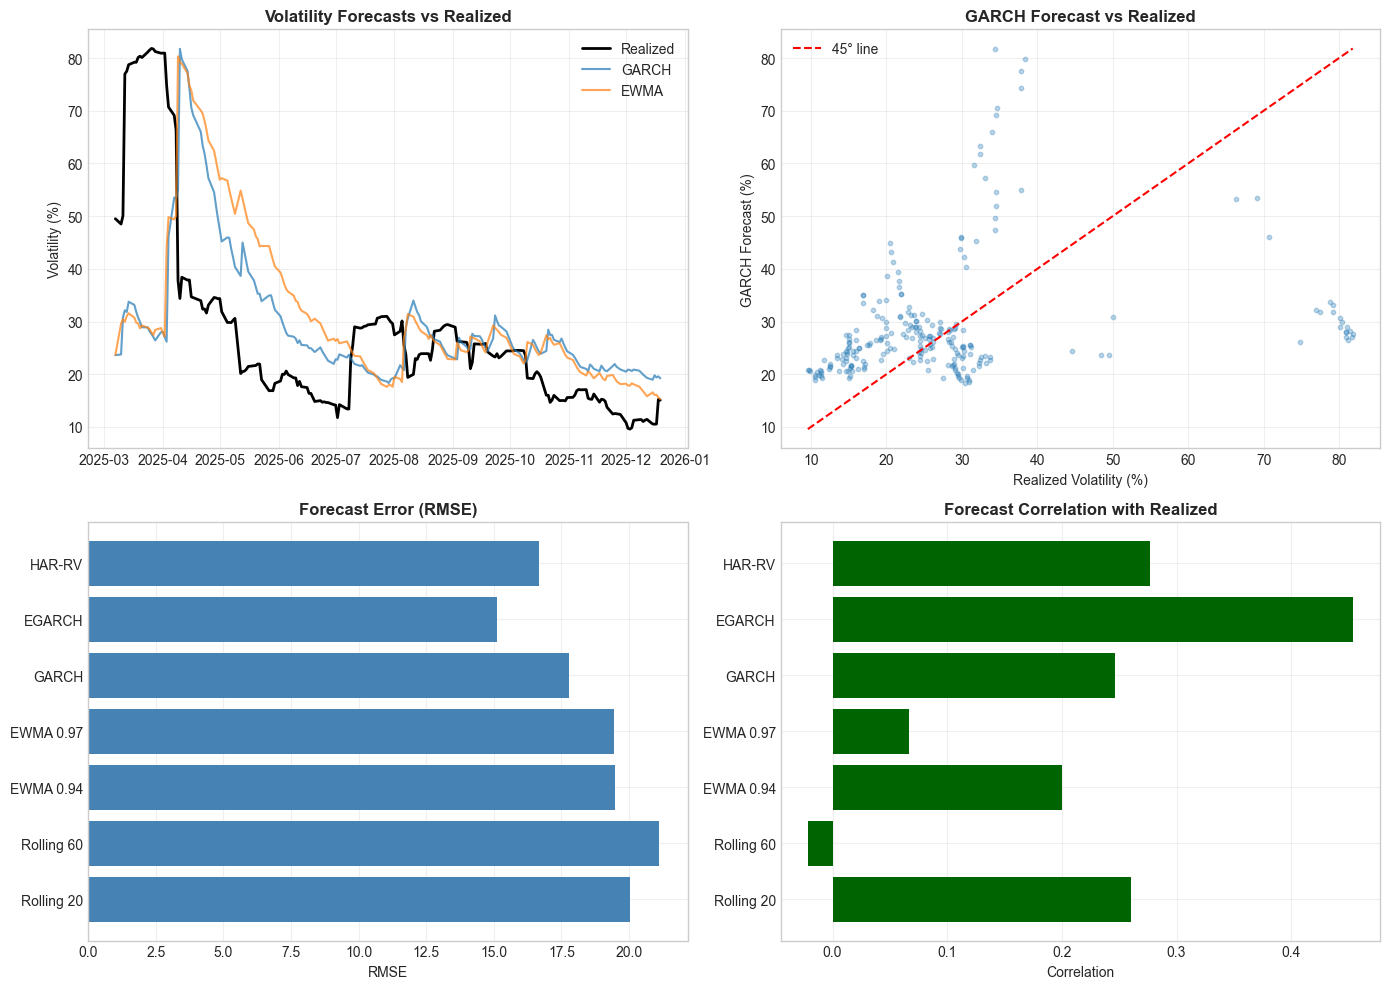

In [26]:
# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series comparison
ax1 = axes[0, 0]
ax1.plot(target.iloc[-200:], label='Realized', color='black', linewidth=2)
ax1.plot(forecasts['GARCH'].loc[target.index].iloc[-200:], label='GARCH', alpha=0.7)
ax1.plot(forecasts['EWMA 0.94'].loc[target.index].iloc[-200:], label='EWMA', alpha=0.7)
ax1.set_title('Volatility Forecasts vs Realized', fontweight='bold')
ax1.set_ylabel('Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter: GARCH vs Realized
ax2 = axes[0, 1]
garch_aligned = forecasts['GARCH'].loc[target.index].dropna()
target_aligned = target.loc[garch_aligned.index]
ax2.scatter(target_aligned, garch_aligned, alpha=0.3, s=10)
ax2.plot([target_aligned.min(), target_aligned.max()], 
         [target_aligned.min(), target_aligned.max()], 'r--', label='45° line')
ax2.set_xlabel('Realized Volatility (%)')
ax2.set_ylabel('GARCH Forecast (%)')
ax2.set_title('GARCH Forecast vs Realized', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Error bar chart
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['RMSE'], color='steelblue')
ax3.set_xlabel('RMSE')
ax3.set_title('Forecast Error (RMSE)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Correlation bar chart
ax4 = axes[1, 1]
ax4.barh(results_df['Model'], results_df['Corr'], color='darkgreen')
ax4.set_xlabel('Correlation')
ax4.set_title('Forecast Correlation with Realized', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Mincer-Zarnowitz Regression

In [27]:
# Mincer-Zarnowitz regression for forecast efficiency
# RV_t = α + β * Forecast_t + ε_t
# Efficient forecast: α = 0, β = 1

from sklearn.linear_model import LinearRegression

print("\n" + "="*70)
print("MINCER-ZARNOWITZ REGRESSION")
print("Efficient forecast: α = 0, β = 1")
print("="*70)
print(f"{'Model':<12} {'α (intercept)':<15} {'β (slope)':<12} {'R²':<10}")
print("-"*50)

for name in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
    forecast = forecasts[name].loc[target.index].dropna()
    target_aligned = target.loc[forecast.index]
    
    X = forecast.values.reshape(-1, 1)
    y = target_aligned.values
    
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    
    print(f"{name:<12} {reg.intercept_:<15.4f} {reg.coef_[0]:<12.4f} {r2:<10.4f}")

print("\n💡 β < 1: Forecast overshoots; β > 1: Forecast undershoots")


MINCER-ZARNOWITZ REGRESSION
Efficient forecast: α = 0, β = 1
Model        α (intercept)   β (slope)    R²        
--------------------------------------------------
GARCH        17.5478         0.3655       0.0605    
EWMA 0.94    20.7123         0.2471       0.0401    
Rolling 20   20.2794         0.2706       0.0679    

💡 β < 1: Forecast overshoots; β > 1: Forecast undershoots


## 5. Different Forecast Horizons

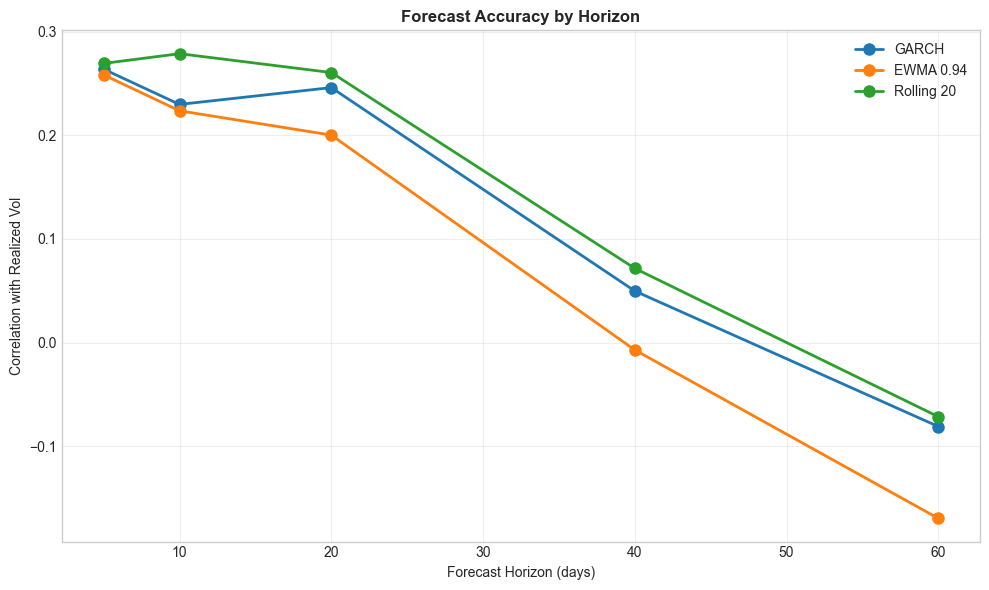


💡 Forecasts typically degrade at longer horizons


In [28]:
# Evaluate at different horizons
horizons = [5, 10, 20, 40, 60]

horizon_results = []
for h in horizons:
    rv_h = calc_realized_vol(ret, h) * 100
    target_h = rv_h.loc[test_idx].dropna()
    
    for method in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
        forecast = forecasts[method]
        common_idx = forecast.dropna().index.intersection(target_h.index)
        f = forecast.loc[common_idx]
        t = target_h.loc[common_idx]
        
        corr = np.corrcoef(t, f)[0, 1]
        horizon_results.append({
            'Horizon': h,
            'Method': method,
            'Correlation': corr
        })

horizon_df = pd.DataFrame(horizon_results)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for method in ['GARCH', 'EWMA 0.94', 'Rolling 20']:
    data = horizon_df[horizon_df['Method'] == method]
    ax.plot(data['Horizon'], data['Correlation'], 'o-', linewidth=2, markersize=8, label=method)

ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Correlation with Realized Vol')
ax.set_title('Forecast Accuracy by Horizon', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Forecasts typically degrade at longer horizons")

## Key Takeaways

1. **GARCH often beats simple methods** for short horizons
2. **EWMA is a good practical choice** - simple and competitive
3. **HAR-RV captures multiple time scales** - good for longer horizons
4. **Mincer-Zarnowitz regression** tests forecast efficiency
5. **All forecasts degrade** at longer horizons

### Key Metrics
- **RMSE**: Penalizes large errors more
- **MAE**: Robust to outliers
- **Correlation**: Measures directional accuracy
- **Mincer-Zarnowitz**: Tests for systematic bias

---
*Next: Day 6 - Volatility Trading Strategies*

## 🔴 PROS & CONS: Volatility Forecasting

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [29]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Volatility Forecasting Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 15:51

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
